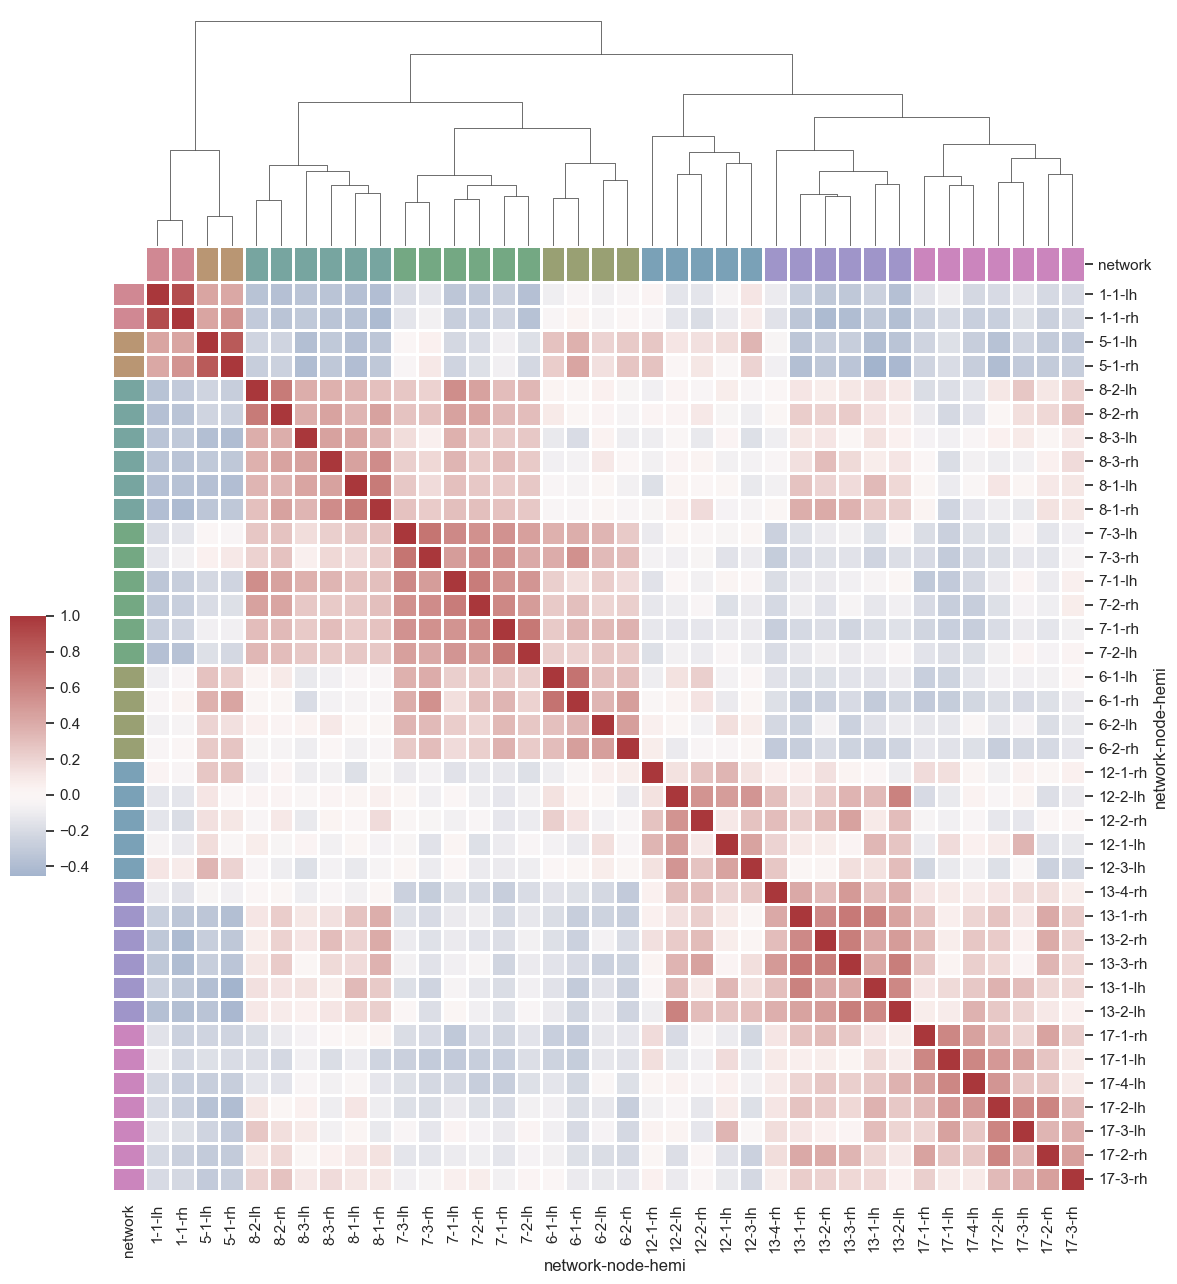

In [1]:
import pandas as pd
import seaborn as sns
sns.set_theme()

# Load the brain networks example dataset
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# Select a subset of the networks
used_networks = [1, 5, 6, 7, 8, 12, 13, 17]
used_columns = (df.columns.get_level_values("network")
                          .astype(int)
                          .isin(used_networks))
df = df.loc[:, used_columns]

# Create a categorical palette to identify the networks
network_pal = sns.husl_palette(8, s=.45)
network_lut = dict(zip(map(str, used_networks), network_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix
networks = df.columns.get_level_values("network")
network_colors = pd.Series(networks, index=df.columns).map(network_lut)

# Draw the full plot
g = sns.clustermap(df.corr(), center=0, cmap="vlag",
                   row_colors=network_colors, col_colors=network_colors,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13))

g.ax_row_dendrogram.remove()

In [5]:
df.columns.names
# Output: ['type', 'region', 'network']


FrozenList(['network', 'node', 'hemi'])

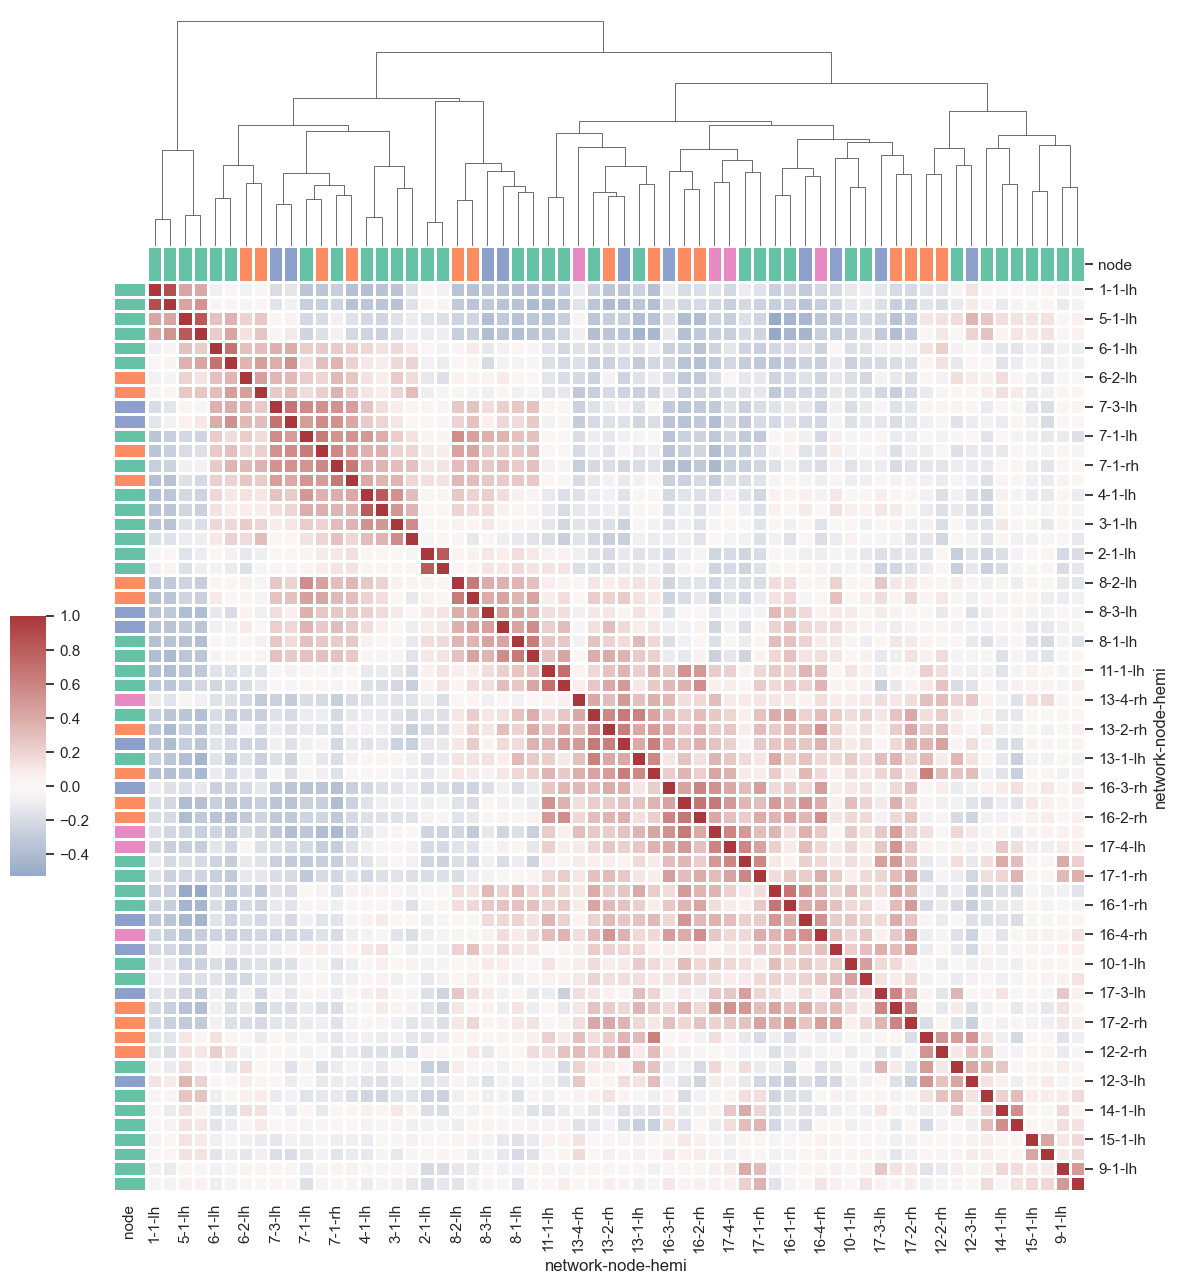

In [6]:
types = df.columns.get_level_values("node")
unique_types = types.unique()

# Build a color palette and lookup table for "type"
type_palette = sns.color_palette("Set2", n_colors=len(unique_types))
type_lut = dict(zip(unique_types, type_palette))
type_colors = pd.Series(types, index=df.columns).map(type_lut)

g = sns.clustermap(df.corr(), center=0, cmap="vlag",
                   row_colors=type_colors,
                   col_colors=type_colors,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13))

g.ax_row_dendrogram.remove()



# scviz test

In [4]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scviz import utils
from scviz import setup

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='paper', style='ticks')

In [130]:
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy import sparse

# ---- STEP 1: Create toy data ----
# 6 samples (obs), 4 proteins (var)
X = np.array([
    [1,    np.nan, 1000,   1000000,  50000,  2.0],     # BE_kd1
    [2,    20000,     np.nan, 200,  500,  2.5],   # BE_kd2
    [np.nan, 30,   30,   np.nan, 500000000,  3.0],   # BE_kd3
    [100,  np.nan, 10000, 500,  50000,  2.8],     # AS_sc1
    [2000000000, 400,     np.nan, np.nan, 50000,  2.2], # AS_sc2
    [np.nan, 600,  30000, 1500, 500,  2.1],     # AS_sc3
])


obs = pd.DataFrame({
    "cellline": ["BE", "BE", "BE", "AS", "AS", "AS"],
    "treatment": ["kd", "kd", "kd", "sc", "sc", "sc"]
}, index=[f"sample{i+1}" for i in range(6)])

var = pd.DataFrame({"Genes": ["GAPDH", "ACTB", "TUBB", "MYH9", "HSP90", "RPLP0"]}, index=[f"P{i+1}" for i in range(6)])

adata = AnnData(X=X, obs=obs, var=var)

# ---- STEP 2: Wrap in dummy pAnnData ----
class DummyPAnnData:
    def __init__(self, adata):
        self.prot = adata
        self.pep = None
        self._history = []
        
    def _check_data(self, on):
        return on == 'protein' and self.prot is not None

    @property
    def _cached_identifier_maps_protein(self):
        if not hasattr(self, "_gene_maps_protein"):
            self._gene_maps_protein = self._build_identifier_maps(self.prot)
        return self._gene_maps_protein

    def set_X(self, layer="X", on="protein"):
        adata = self.prot if on == "protein" else self.pep
        adata.X = adata.layers[layer].copy()
        print(f"ℹ️ Set {on} data to layer {layer}.")

    def get_gene_maps(self, on='protein'):
        """
        Returns identifier mapping dictionaries:
        - on='protein': (gene → accession, accession → gene)
        - on='peptide': (protein accession → peptide, peptide → protein accession)

        Alias: get_gene_maps() for compatibility.
        """
        if on == 'protein':
            return self._cached_identifier_maps_protein
        else:
            raise ValueError(f"Invalid value for 'on': {on}. Must be 'protein' or 'peptide'.")

    def _build_identifier_maps(self, adata, gene_col="Genes"):
        """
        Builds bidirectional mapping for:
        - protein: gene ↔ accession
        - peptide: peptide ↔ protein accession

        Returns: (forward, reverse)
        """
        from pandas import notna

        forward = {}
        reverse = {}

        if adata is self.prot:
            if gene_col in adata.var.columns:
                for acc, gene in zip(adata.var_names, adata.var[gene_col]):
                    if notna(gene):
                        gene = str(gene)
                        forward[gene] = acc
                        reverse[acc] = gene

        elif adata is self.pep:
            prot_acc_col = utils.get_pep_prot_mapping(self)
            pep_to_prot = adata.var[prot_acc_col]
            for pep, prot in zip(adata.var_names, pep_to_prot):
                if notna(prot):
                    forward[prot] = pep
                    reverse[pep] = prot

        return forward, reverse

pdata = DummyPAnnData(adata)


In [138]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

def plot_heatmap(pdata, classes=None, layer="X", cmap="seismic",
                 norm_values=[0, 2.5, 4], annotate=True,
                 square=False, figsize=(10, 6)):
    """
    Plot annotated heatmap of protein abundance with header color bar.

    Parameters
    ----------
    pdata : pAnnData
        Object containing .prot layer with abundance data.
    classes : str or list of str, optional
        Sample metadata column(s) to group by.
    layer : str
        Layer to use for abundance (default: "X").
    cmap : str or Colormap
        Colormap to use (default: seismic).
    norm_values : list of float
        [min, center, max] values for TwoSlopeNorm scaling.
    annotate : bool
        Whether to add numerical annotations.
    square : bool
        Whether to make heatmap cells square.
    figsize : tuple
        Figure size.

    Returns
    -------
    fig : matplotlib.figure.Figure
    ax_header, ax_heat : matplotlib.axes.Axes
    """
    adata = pdata.prot
    data = adata.layers[layer] if layer != "X" else adata.X
    data = data.toarray() if hasattr(data, 'toarray') else data.copy()

    # Handle class labels and sorting
    if classes is not None:
        group_labels = adata.obs[classes].astype(str)
        if isinstance(classes, list):
            group_labels = group_labels.agg('_'.join, axis=1)
        group_labels = group_labels.values
        sort_idx = np.argsort(group_labels)
        data = data[sort_idx]
        group_labels = group_labels[sort_idx]
        sample_names = adata.obs_names[sort_idx]
    else:
        group_labels = np.array([""] * data.shape[0])
        sample_names = adata.obs_names

    # Map group → color
    unique_groups = np.unique(group_labels)
    palette = plt.get_cmap("tab10").colors
    group_color_map = {g: palette[i % len(palette)] for i, g in enumerate(unique_groups)}
    col_colors_rgb = np.array([group_color_map[g] for g in group_labels])  # shape: (n_samples, 3)

    # Log-transform
    with np.errstate(divide='ignore', invalid='ignore'):
        data_log = np.log10(data)
        data_log[np.isneginf(data_log)] = np.nan

    # Normalize
    norm = mcolors.TwoSlopeNorm(vmin=norm_values[0],
                                vcenter=norm_values[1],
                                vmax=norm_values[2])

    n_samples = data.shape[0]
    n_proteins = data.shape[1]

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[0.1, 1], hspace=0.05)

    # Header color bar (top)
    ax_header = fig.add_subplot(gs[0])
    x = np.arange(n_samples + 1)
    y = np.array([0, 1])
    ax_header.pcolormesh(x, y, np.zeros((1, n_samples)), facecolors=col_colors_rgb, edgecolors='none')
    ax_header.set_xlim(0, n_samples)
    ax_header.set_ylim(0, 1)
    ax_header.set_xticks([])
    ax_header.set_yticks([])
    ax_header.set_frame_on(False)

    # Main heatmap
    ax_heat = fig.add_subplot(gs[1])
    heat = ax_heat.pcolormesh(np.arange(n_samples + 1), np.arange(n_proteins + 1),
                              data_log.T, cmap=cmap, norm=norm,
                              edgecolors='w', linewidth=0.5)

    ax_heat.set_xlim(0, n_samples)
    ax_heat.set_ylim(0, n_proteins)
    ax_heat.set_xticks(np.arange(n_samples) + 0.5)
    ax_heat.set_xticklabels(sample_names, rotation=45, ha="right")
    ax_heat.set_yticks(np.arange(n_proteins) + 0.5)
    ax_heat.set_yticklabels(adata.var["Genes"])
    ax_heat.set_xlabel("Samples")
    ax_heat.set_ylabel("Proteins")

    # Optional annotations
    if annotate:
        for i in range(n_samples):
            for j in range(n_proteins):
                val = data_log[i, j]
                if not np.isnan(val):
                    ax_heat.text(i + 0.5, j + 0.5, f"{val:.1f}", ha="center", va="center", fontsize=8)

    # Colorbar
    cbar = fig.colorbar(heat, ax=ax_heat, pad=0.02)
    cbar.set_label("Abundance (log₁₀ AU)")

    # Legend
    handles = [mpatches.Patch(color=c, label=g) for g, c in group_color_map.items()]
    ax_heat.legend(handles=handles, title="Group", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    if square:
        ax_heat.set_aspect("equal")

    plt.tight_layout()
    return fig, (ax_header, ax_heat)


In [232]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from scviz import utils  # Adjust as needed for your package

def plot_clustermap(ax, pdata, on='prot', classes=None, layer="X", x_label='accession', namelist=None, lut=None, log2=True,
                    cmap="coolwarm", figsize=(6, 10), force=False, impute=None, **kwargs):
    """
    Plot a clustered heatmap (proteins × samples) with optional column annotations and hierarchical clustering.

    Parameters:
        ax: Unused; included for compatibility with scviz plotting API.
        pdata: pAnnData object.
        on: 'prot' or 'pep' (choose data matrix).
        classes: str or list of str. Sample class columns to annotate in the heatmap.
        layer: str. Layer name to use; defaults to .X.
        x_label: 'accession' or 'gene'. Used for row names and namelist mapping.
        namelist: Optional list of protein accessions or gene names to plot.
        lut: Optional nested dict of {class_name: {label: color}}.
            This controls annotation bar colors. Missing entries are filled using default palettes.

            Example:
                lut = {
                    "cellline": {
                        "AS": "#e41a1c",
                        "BE": "#377eb8"
                    },
                    "condition": {
                        "kd": "#4daf4a",
                        "sc": "#984ea3"
                    }
                }

        log2: Whether to log2-transform the abundance matrix (default: True).
        cmap: Colormap for heatmap (default: 'coolwarm').
        figsize: Tuple for figure size.
        force: If True, imputes missing protein values instead of dropping rows with NaNs.
        impute: Imputation strategy used when force=True. Options:
            - 'row_min': fill NaNs with minimum value in that protein row
            - 'global_min': fill NaNs with global minimum value in matrix

        **kwargs: Additional arguments passed to seaborn.clustermap().
            Common options:
                - z_score (int): Normalize rows (0) or columns (1).
                - standard_scale (int): Scale rows or columns to unit variance.
                - center (float): Value to center colormap on (e.g., 0 with z_score).
                - col_cluster (bool): Whether to cluster columns (samples). Default: False
                - row_cluster (bool): Whether to cluster rows (proteins). Default: True
                - linewidth (float): Grid line width between cells.
                - xticklabels / yticklabels (bool): Show axis tick labels.
                - colors_ratio (tuple): Proportion of space allocated to annotation bars.
    """
    # --- Step 1: Extract data ---
    if on not in ("prot", "pep"):
        raise ValueError(f"`on` must be 'prot' or 'pep', got '{on}'")
    
    if namelist is not None:
        df_abund = utils.get_abundance(
        pdata, namelist=namelist, layer=layer, on=on,
        classes=classes, log=log2, x_label=x_label)
        
        pivot_col = "log2_abundance" if log2 else "abundance"
        row_index = "gene" if x_label == "gene" else "accession"
        df = df_abund.pivot(index=row_index, columns="cell", values=pivot_col)
    
    else:
        adata = pdata.prot if on == 'prot' else pdata.pep
        X = adata.layers[layer] if layer in adata.layers else adata.X
        data = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
        df = pd.DataFrame(data.T, index=adata.var_names, columns=adata.obs_names)
        if log2:
            with np.errstate(divide='ignore', invalid='ignore'):
                df = np.log2(df)
                df[df == -np.inf] = np.nan

    # --- Handle missing values ---
    nan_rows = df.index[df.isna().any(axis=1)].tolist()
    if nan_rows:
        if not force:
            print(f"Warning: {len(nan_rows)} proteins contain missing values and will be excluded: {nan_rows}")
            print("To include them, rerun with force=True and impute='row_min' or 'global_min'.")
            df = df.drop(index=nan_rows)
        else:
            print(f"{len(nan_rows)} proteins contain missing values: {nan_rows}.\nImputing using strategy: '{impute}'")
            if impute == "row_min":
                df = df.apply(lambda row: row.fillna(row.min()), axis=1)
            elif impute == "global_min":
                df = df.fillna(df.min().min())
            else:
                raise ValueError("`impute` must be either 'row_min' or 'global_min' when force=True.")

    # --- Step 2: Column annotations ---
    col_colors = None
    legend_handles, legend_labels = [], []

    if classes is not None:
        if isinstance(classes, str):
            sample_labels = utils.get_samplenames(adata, classes)
            annotations = pd.DataFrame({classes: sample_labels}, index=adata.obs_names)
        else:
            sample_labels = utils.get_samplenames(adata, classes)
            split_labels = [[part.strip() for part in s.split(",")] for s in sample_labels]
            annotations = pd.DataFrame(split_labels, index=adata.obs_names, columns=classes)

        if lut is None:
            lut = {}

        full_lut = {}
        for col in annotations.columns:
            unique_vals = sorted(annotations[col].dropna().unique())
            user_colors = lut.get(col, {})
            missing_vals = [v for v in unique_vals if v not in user_colors]
            fallback_palette = sns.color_palette(n_colors=len(missing_vals))
            fallback_colors = dict(zip(missing_vals, fallback_palette))
            full_lut[col] = {**user_colors, **fallback_colors}

            unmatched = set(user_colors) - set(unique_vals)
            if unmatched:
                print(f"Warning: The following labels in `lut['{col}']` are not found in the data: {sorted(unmatched)}")

        col_colors = annotations.apply(lambda col: col.map(full_lut[col.name]))

        # Legend handles
        for col in annotations.columns:
            legend_handles.append(mpatches.Patch(facecolor="none", edgecolor="none", label=col))  # header
            for label, color in full_lut[col].items():
                legend_handles.append(mpatches.Patch(facecolor=color, edgecolor="black", label=label))
            legend_labels.extend([col] + list(full_lut[col].keys()))

    # --- Step 3: Clustermap defaults (user-overridable) ---
    col_cluster = kwargs.pop("col_cluster", False)
    row_cluster = kwargs.pop("row_cluster", True)
    linewidth = kwargs.pop("linewidth", 0.1)
    yticklabels = kwargs.pop("yticklabels", True)
    xticklabels = kwargs.pop("xticklabels", True)
    colors_ratio = kwargs.pop("colors_ratio", (0.03, 0.02))

    # --- Step 4: Plot clustermap ---
    g = sns.clustermap(df,
                       cmap=cmap,
                       col_cluster=col_cluster,
                       row_cluster=row_cluster,
                       col_colors=col_colors,
                       figsize=figsize,
                       xticklabels=xticklabels,
                       yticklabels=yticklabels,
                       linewidth=linewidth,
                       colors_ratio=colors_ratio,
                       **kwargs)

    # --- Step 5: Column annotation legend ---
    if classes is not None:
        g.ax_col_dendrogram.legend(legend_handles, legend_labels,
                                   title=None,
                                   bbox_to_anchor=(0.5, 1.15),
                                   loc="upper center",
                                   ncol=len(classes),
                                   handletextpad=0.5,
                                   columnspacing=1.5,
                                   frameon=False)
        
    # --- Step 6: Row label remapping ---
    if x_label == "gene":
        _ , prot_map = pdata.get_gene_maps(on='protein' if on == 'prot' else 'peptide')
        row_labels = [prot_map.get(row, row) for row in g.data2d.index]
        g.ax_heatmap.set_yticklabels(row_labels, rotation=0)

    # --- Step 8: Store clustering results ---
    cluster_key  = f"{on}_{layer}_clustermap"
    row_order = list(g.data2d.index)
    row_indices = g.dendrogram_row.reordered_ind

    pdata.stats[cluster_key]  = {
        "row_order": row_order,
        "row_indices": row_indices,
        "row_labels": x_label,   # 'accession' or 'gene'
        "namelist_used": namelist if namelist is not None else "all_proteins",
        "col_order": list(g.data2d.columns),
        "col_indices": g.dendrogram_col.reordered_ind if g.dendrogram_col else None,
        "row_linkage": g.dendrogram_row.linkage,  # <--- NEW
        "col_linkage": g.dendrogram_col.linkage if g.dendrogram_col else None,
    }

    return g


In [231]:
from scipy.cluster.hierarchy import fcluster

def get_protein_clusters(pdata, on='prot', layer='X', t=5, criterion='maxclust'):
    """
    Returns a dict mapping cluster_id → list of proteins, using stored linkage.
    
    Parameters:
        t: number of clusters (if criterion='maxclust') or distance threshold
        criterion: 'maxclust', 'distance', etc. (see scipy fcluster)
    """
    key = f"{on}_{layer}_clustermap"
    stats = pdata.stats.get(key)
    if not stats or "row_linkage" not in stats:
        print(f"No linkage found for {key} in pdata.stats.")
        return None

    linkage = stats["row_linkage"]
    labels = fcluster(linkage, t=t, criterion=criterion)
    order = stats["row_order"]

    from collections import defaultdict
    clusters = defaultdict(list)
    for label, prot in zip(labels, order):
        clusters[label].append(prot)

    return dict(clusters)


In [148]:
from scviz import pAnnData

pdata = pAnnData.import_data(source_type='pd', prot_file='pd_prot_short.txt', obs_columns=['Sample','cellline', 'condition'])

🧭 [USER] Importing data of type [pd]
--------------------------
Starting import [Proteome Discoverer]
--------------------------
Source file: pd_prot_short.txt / None
Number of files: 12
Proteins: 6

          🔄 [UPDATE] Updating summary [recompute]: Recomputed metrics and refreshed `.summary` from `.obs`.

     ✅ [OK] pAnnData object is valid.
--------------------------
     ✅ [OK] Import complete. Use `print(pdata)` to view the object.


In [189]:
pdata.prot.obs.condition.unique()

['kd', 'sc']
Categories (2, object): ['kd', 'sc']

1 proteins contain missing values: ['Q6ZRP7'].
Imputing using strategy: 'row_min'


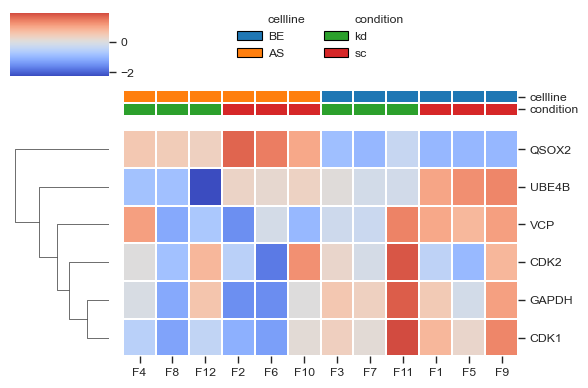

In [233]:
# fig, ax = plt.subplots(figsize=(10, 6))
from matplotlib.pyplot import color_sequences


color_palette={
    'cellline': {'BE': '#1f77b4', 'AS': '#ff7f0e'},
    'condition': {'kd': '#2ca02c', 'sc': '#d62728'}
}
plot_clustermap(ax, pdata, classes=["cellline",'condition'], lut=color_palette, force=True, impute='row_min', z_score=0, center=0, figsize=(6,4), colors_ratio=0.04, x_label='gene')
plt.tight_layout()

In [235]:
get_protein_clusters(pdata)

{1: ['Q6ZRP7', 'P55072', 'P06493'],
 2: ['O95155'],
 3: ['P24941'],
 4: ['P04406']}

In [217]:
pdata.de(values=[{'cellline': 'BE', 'condition': 'kd'}, {'cellline': 'BE', 'condition': 'sc'}])

🧭 [USER] Running differential expression [protein]
   🔸 Comparing groups: [{'cellline': 'BE', 'condition': 'kd'}] vs [{'cellline': 'BE', 'condition': 'sc'}]
   🔸 Group sizes: 3 vs 3 samples
   🔸 Method: ttest | Fold Change: mean | Layer: X
   🔸 P-value threshold: 0.05 | Log2FC threshold: 1.0
     ✅ DE complete. Results stored in:
       • .stats["[{'cellline': 'BE', 'condition': 'kd'}] vs [{'cellline': 'BE', 'condition': 'sc'}]"]
       • Columns: log2fc, p_value, significance, etc.
       • Upregulated: 0 | Downregulated: 1 | Not significant: 4


,Genes,"[{'cellline': 'BE', 'condition': 'kd'}]","[{'cellline': 'BE', 'condition': 'sc'}]",log2fc,p_value,test_statistic,-log10(p_value),significance_score,significance
O95155,UBE4B,1.155537e+05,3.553881e+05,-1.620832,0.001519,-7.716064,2.818562,-4.568416,downregulated
P04406,GAPDH,7.656934e+08,7.048131e+08,0.119526,0.500656,0.739491,0.300461,0.035913,not significant
P55072,VCP,9.445237e+07,1.072612e+08,-0.183470,0.339198,-1.084344,0.469546,-0.086148,not significant
P24941,CDK2,2.391923e+06,1.953841e+06,0.291858,0.352252,1.051755,0.453146,0.132254,not significant
P06493,CDK1,2.123671e+07,2.078322e+07,0.031141,0.924822,0.100448,0.033942,0.001057,not significant


In [225]:
pdata.stats

{"[{'cellline': 'BE', 'condition': 'kd'}] vs [{'cellline': 'BE', 'condition': 'sc'}]":         Genes  [{'cellline': 'BE', 'condition': 'kd'}]  \
 O95155  UBE4B                             1.155537e+05   
 P04406  GAPDH                             7.656934e+08   
 P55072    VCP                             9.445237e+07   
 P24941   CDK2                             2.391923e+06   
 P06493   CDK1                             2.123671e+07   
 
         [{'cellline': 'BE', 'condition': 'sc'}]    log2fc   p_value  \
 O95155                             3.553881e+05 -1.620832  0.001519   
 P04406                             7.048131e+08  0.119526  0.500656   
 P55072                             1.072612e+08 -0.183470  0.339198   
 P24941                             1.953841e+06  0.291858  0.352252   
 P06493                             2.078322e+07  0.031141  0.924822   
 
         test_statistic  -log10(p_value)  significance_score     significance  
 O95155       -7.716064         2.818562    

In [215]:
pdata.prot.uns

OrderedDict([('metadata',
              {'source': 'proteomeDiscoverer',
               'prot_file': 'pd_prot_short.txt',
               'pep_file': None,
               'imported_at': '2025-06-29T13:57:31.963734'}),
             ('prot_X_clustermap',
              {'row_order': ['Q6ZRP7',
                'O95155',
                'P55072',
                'P24941',
                'P04406',
                'P06493'],
               'row_indices': [4, 3, 1, 2, 0, 5],
               'row_labels': 'gene',
               'namelist_used': 'all_proteins',
               'col_order': ['F4',
                'F8',
                'F12',
                'F2',
                'F6',
                'F10',
                'F3',
                'F7',
                'F11',
                'F1',
                'F5',
                'F9'],
               'col_indices': None})])

In [207]:
gene_map, prot_map = pdata.get_gene_maps(on='protein')

gene_map

{'GAPDH': 'P04406',
 'VCP': 'P55072',
 'CDK2': 'P24941',
 'UBE4B': 'O95155',
 'QSOX2': 'Q6ZRP7',
 'CDK1': 'P06493'}

In [ ]:
namelist=list(pdata.prot.var_names)

df = utils.get_abundance(
        pdata, namelist=namelist, layer="X", on="protein",
        classes=["cellline",'condition'], log=True, x_label='accession'
    )

print(df)

   cell accession     abundance index  Sample cellline condition  \
0    F4    P04406  6.318343e+08    F4  Sample       AS        kd   
1    F4    P55072  1.104558e+08    F4  Sample       AS        kd   
2    F4    P24941  2.044752e+06    F4  Sample       AS        kd   
3    F4    O95155  6.212859e+04    F4  Sample       AS        kd   
4    F4    Q6ZRP7  2.165753e+05    F4  Sample       AS        kd   
..  ...       ...           ...   ...     ...      ...       ...   
67   F9    P55072  1.104852e+08    F9  Sample       BE        sc   
68   F9    P24941  2.421021e+06    F9  Sample       BE        sc   
69   F9    O95155  3.992941e+05    F9  Sample       BE        sc   
70   F9    Q6ZRP7           NaN    F9  Sample       BE        sc   
71   F9    P06493  2.465035e+07    F9  Sample       BE        sc   

    protein_quant  protein_count  protein_abundance_sum  mbr_count  \
0        1.000000              6           7.580381e+08          2   
1        1.000000              6           

# test

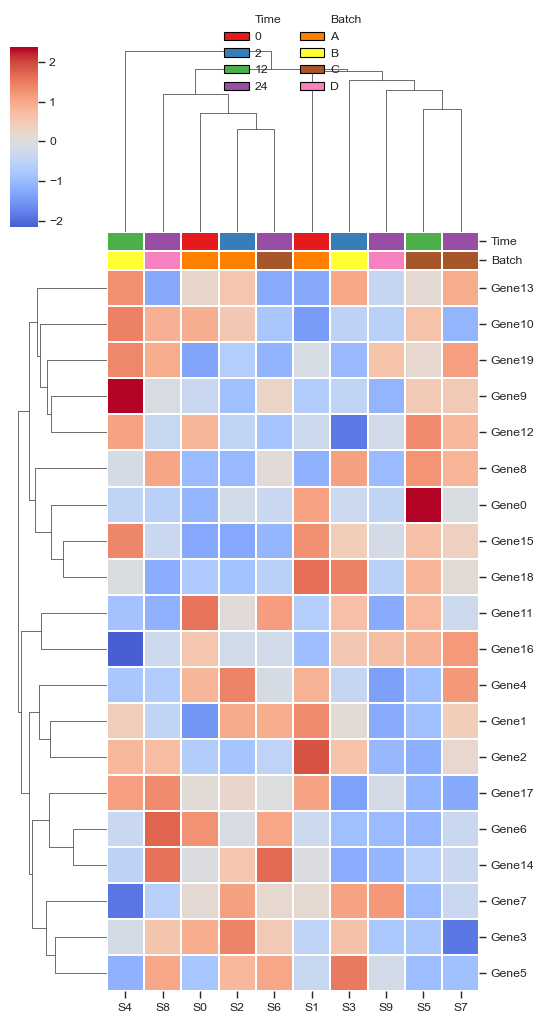

In [128]:
# Re-import necessary libraries due to code execution state reset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Step 1: Simulated expression data ---
data = np.random.rand(20, 10)
genes = [f"Gene{i}" for i in range(20)]
samples = [f"S{i}" for i in range(10)]
df = pd.DataFrame(data, index=genes, columns=samples)

# --- Step 2: Sample annotations ---
annotations = pd.DataFrame({
    "Time": ["0", "0", "2", "2", "12", "12", "24", "24", "24", "24"],
    "Batch": ["A", "A", "A", "B", "B", "C", "C", "C", "D", "D"]
}, index=samples)

# --- Step 3: Color lookup tables ---
lut = {
    "Time": {"0": "#e41a1c", "2": "#377eb8", "12": "#4daf4a", "24": "#984ea3"},
    "Batch": {"A": "#ff7f00", "B": "#ffff33", "C": "#a65628", "D": "#f781bf"}
}

# --- Step 4: Map annotations to colors ---
col_colors = pd.DataFrame({
    "Time": annotations["Time"].map(lut["Time"]),
    "Batch": annotations["Batch"].map(lut["Batch"])
}, index=annotations.index)

# --- Step 5: Clustermap ---
g = sns.clustermap(df,
                   cmap="coolwarm",
                   col_cluster=True,
                   row_cluster=True,
                   col_colors=col_colors,
                   figsize=(5.5, 10),
                   xticklabels=True,
                   yticklabels=True,
                   linewidth=0.1,
                   colors_ratio=(0.03, 0.02),
                   z_score=0, center=0)


# --- Step 6: Build legend with column titles ---
# 1. Invisible patches as headers (white square with no edge)
header_handles = [
    Patch(facecolor="none", edgecolor="none", label="Time"),
    Patch(facecolor="none", edgecolor="none", label="Batch")
]

# 2. Normal category entries
time_handles = [Patch(facecolor=color, edgecolor='black') for color in lut["Time"].values()]
time_labels = list(lut["Time"].keys())

batch_handles = [Patch(facecolor=color, edgecolor='black') for color in lut["Batch"].values()]
batch_labels = list(lut["Batch"].keys())

# 3. Interleave as columns: use zip + flatten
handles = [header_handles[0]] + time_handles + [header_handles[1]] + batch_handles
labels = ["Time"] + time_labels + ["Batch"] + batch_labels

# Plot legend manually
g.ax_col_dendrogram.legend(handles, labels,
                           title=None,
                           bbox_to_anchor=(0.5, 1.2),
                           loc="upper center",
                           ncol=2,
                           handletextpad=0.5,
                           columnspacing=1.5,
                           frameon=False)

# g.ax_heatmap.set_aspect("equal", adjustable="box")

plt.show()

# plt.tight_layout()
plt.show()
